In [38]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
from torchvision import transforms

from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [39]:
device = "cpu"

In [40]:
image_path = "data/pizza_steak_sushi"

In [41]:
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [42]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    manual_transforms,
    BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x15efc331e50>,
 ['pizza', 'steak', 'sushi'])

In [43]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

c:\Users\soseb\OneDrive\Documents\ViT-Paper-Replication\.venv\Lib\site-packages\torch\utils\data\dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


(torch.Size([3, 224, 224]), tensor(1))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

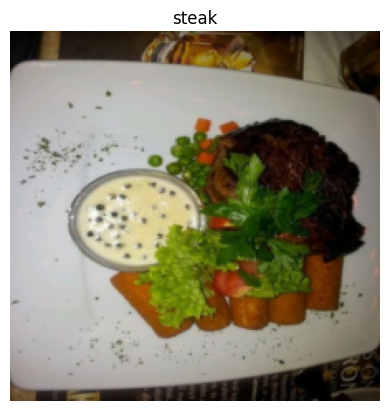

In [44]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [45]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height*width) / patch_size**2)
number_of_patches

196

In [46]:
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

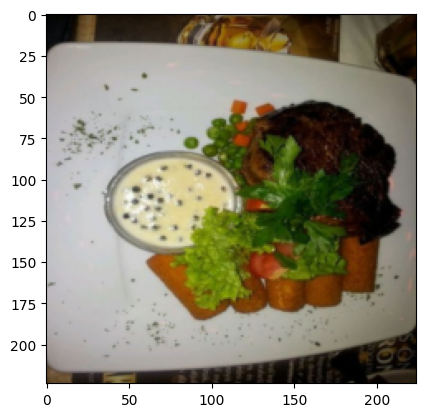

In [47]:
plt.imshow(image.permute(1, 2, 0))

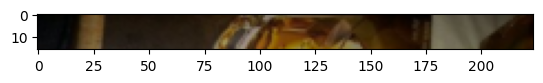

In [48]:
image_permuted = image.permute(1, 2, 0)

plt.Figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


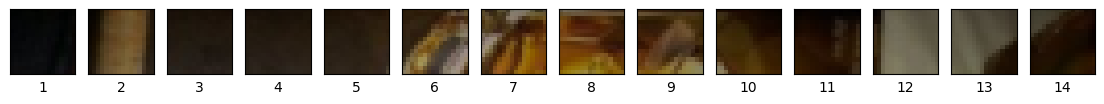

In [49]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [50]:
from torch import nn
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

In [51]:
image.shape

torch.Size([3, 224, 224])

In [52]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


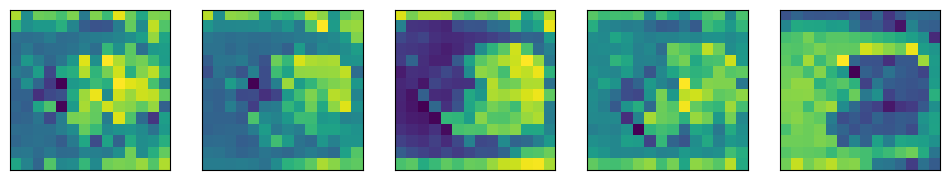

In [53]:
import random 
random_indexes = random.sample(range(0, 758), k=5)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [54]:
print(f"Current tensor shape: {image_out_of_conv.shape}")

Current tensor shape: torch.Size([1, 768, 14, 14])


In [55]:
flatten = nn.Flatten(start_dim=2, end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


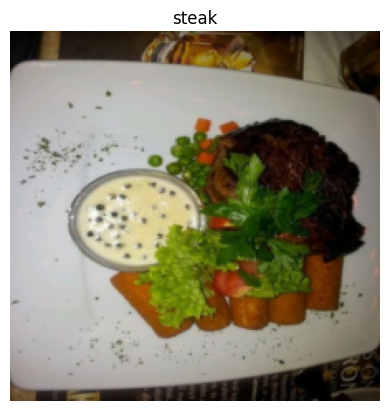

In [56]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [57]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape: torch.Size([1, 196, 768])


In [58]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size: int=16, embedding_dim: int=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)

In [59]:
set_seeds()

patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [60]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)



In [61]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)


In [62]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [63]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

In [64]:
set_seeds()

patch_size = 16

height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)


patch_embedding = patch_embedding_layer(x)

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)

number_of_patches = int((height*width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Patch and position embedding shape: torch.Size([1, 197, 768])


In [65]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim: int=768, num_heads: int=12, attn_dropout: float=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)

        return attn_output

In [66]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [67]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim: int=768, mlp_size: int=3072, dropout: float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [68]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim: int=768, num_heads: int=12, mlp_size: int=3072, mlp_dropout: float=0.1, attn_dropout: float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)

        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        # Resudual connections where you add the input back to the output
        return x
        

In [69]:
transformer_encoder_block = TransformerEncoderBlock()

In [70]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [71]:
class ViT(nn.Module):
    def __init__(self, 
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 num_transformer_layers: int=12,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 num_heads: int=12,
                 attn_dropout: float=0,
                 mlp_dropout: float=0.1,
                 embedding_dropout: float=0.1,
                 num_classes: int=1000):
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])

        return x

In [72]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[0.2525, 0.8748, 1.2374]], grad_fn=<AddmmBackward0>)

In [74]:
from going_modular import engine

optimiser = torch.optim.Adam(params=vit.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()
set_seeds()
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimiser,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\soseb\OneDrive\Documents\ViT-Paper-Replication\.venv\Lib\site-packages\torch\utils\data\dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
 10%|█         | 1/10 [06:20<57:08, 380.92s/it]

Epoch: 1 | train_loss: 5.3084 | train_acc: 0.3594 | test_loss: 5.1902 | test_acc: 0.2604


 20%|██        | 2/10 [10:53<42:15, 316.97s/it]

Epoch: 2 | train_loss: 1.7237 | train_acc: 0.2578 | test_loss: 1.1932 | test_acc: 0.5417


 30%|███       | 3/10 [15:21<34:23, 294.83s/it]

Epoch: 3 | train_loss: 1.3010 | train_acc: 0.2773 | test_loss: 1.2872 | test_acc: 0.2604


 40%|████      | 4/10 [20:23<29:46, 297.68s/it]

Epoch: 4 | train_loss: 1.1275 | train_acc: 0.4375 | test_loss: 1.5563 | test_acc: 0.2604


 50%|█████     | 5/10 [25:13<24:34, 294.95s/it]

Epoch: 5 | train_loss: 1.1600 | train_acc: 0.3008 | test_loss: 1.1372 | test_acc: 0.1979


 60%|██████    | 6/10 [29:55<19:21, 290.47s/it]

Epoch: 6 | train_loss: 1.1993 | train_acc: 0.2969 | test_loss: 1.0813 | test_acc: 0.5417


 70%|███████   | 7/10 [34:26<14:12, 284.14s/it]

Epoch: 7 | train_loss: 1.1460 | train_acc: 0.2930 | test_loss: 1.0362 | test_acc: 0.5417


 80%|████████  | 8/10 [38:53<09:17, 278.55s/it]

Epoch: 8 | train_loss: 1.1900 | train_acc: 0.2773 | test_loss: 1.0829 | test_acc: 0.5417


 90%|█████████ | 9/10 [43:22<04:35, 275.50s/it]

Epoch: 9 | train_loss: 1.0921 | train_acc: 0.4023 | test_loss: 1.2652 | test_acc: 0.1979


100%|██████████| 10/10 [48:00<00:00, 288.07s/it]

Epoch: 10 | train_loss: 1.1485 | train_acc: 0.4141 | test_loss: 1.2495 | test_acc: 0.2604
